In [ ]:
# 1. Setup
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
from PIL import Image



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
dataset_dir = path +"/train"
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [ ]:
# 2. Upload ZIP File
#uploaded = files.upload()
#for fname in uploaded.keys():
#    zip_path = fname

# Unzip
dataset_dir = '/content/drive/MyDrive/dataset'
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(dataset_dir)

# List folders
os.listdir(dataset_dir)


['ai', 'real']

In [ ]:
# 3. Transforms and DataLoader
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Full dataset
full_dataset = datasets.ImageFolder(dataset_dir, transform=transform['train'])

# Split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes
print(f"Classes: {class_names}")


Classes: ['ai', 'real']


In [ ]:
# 4. Load Pretrained ResNet50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


In [ ]:
# 5. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [ ]:
# 6. Train & Evaluate Functions
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    return running_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return (running_loss / len(loader.dataset),
            correct / len(loader.dataset),
            all_preds,
            all_labels)


In [ ]:
# 7. Training Loop
epochs = 6
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, preds, labels = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
Train Loss: 0.4928 | Train Acc: 0.7663
Val Loss:   0.4469 | Val Acc:   0.7889
Epoch 2/20
Train Loss: 0.4345 | Train Acc: 0.8004
Val Loss:   0.4232 | Val Acc:   0.7955
Epoch 3/20
Train Loss: 0.4188 | Train Acc: 0.8100
Val Loss:   0.4130 | Val Acc:   0.8126
Epoch 4/20
Train Loss: 0.3930 | Train Acc: 0.8215
Val Loss:   0.4318 | Val Acc:   0.8032
Epoch 5/20
Train Loss: 0.4133 | Train Acc: 0.8124
Val Loss:   0.4156 | Val Acc:   0.8026
Epoch 6/20
Train Loss: 0.4061 | Train Acc: 0.8190
Val Loss:   0.4959 | Val Acc:   0.7613
Epoch 7/20
Train Loss: 0.4179 | Train Acc: 0.8126
Val Loss:   0.4223 | Val Acc:   0.8104
Epoch 8/20
Train Loss: 0.4008 | Train Acc: 0.8185
Val Loss:   0.4230 | Val Acc:   0.8049
Epoch 9/20
Train Loss: 0.3772 | Train Acc: 0.8305
Val Loss:   0.3804 | Val Acc:   0.8275
Epoch 10/20
Train Loss: 0.3708 | Train Acc: 0.8393
Val Loss:   0.4008 | Val Acc:   0.8153
Epoch 11/20
Train Loss: 0.3872 | Train Acc: 0.8312
Val Loss:   0.3758 | Val Acc:   0.8297
Epoch 12/20
Train L


Classification Report:
              precision    recall  f1-score   support

          ai       0.78      0.60      0.68       529
        real       0.85      0.93      0.89      1285

    accuracy                           0.83      1814
   macro avg       0.81      0.76      0.78      1814
weighted avg       0.83      0.83      0.83      1814



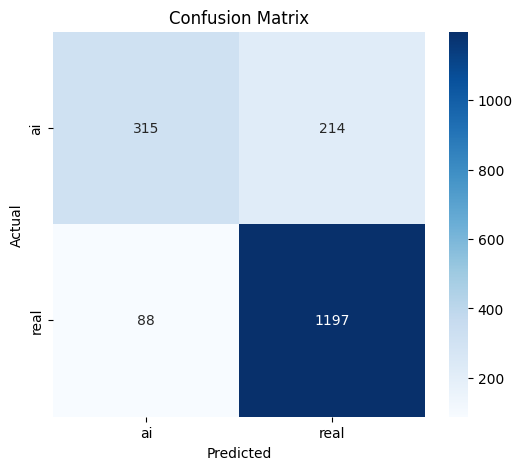

In [ ]:
# 8. Metrics Report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=class_names))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# 9. Save Model
torch.save(model.state_dict(), 'resnet50_ai_vs_real_v2.pt')
files.download('resnet50_ai_vs_real_v2.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('/content/drive/MyDrive/resnet50_ai_vs_real_v2.pt', map_location=device))
model = model.to(device)
model.eval()

# Class names (same as training)
class_names = ['ai', 'real']

# Preprocessing (same as training val transform)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


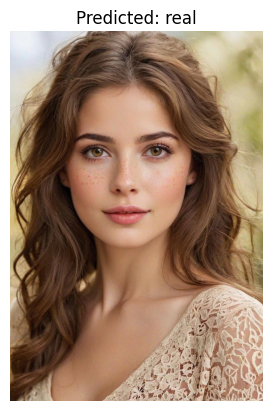

'real'

In [ ]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = class_names[predicted.item()]

    # Show the image with prediction
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

# 🔍 Example usage
predict_image('/content/drive/MyDrive/testdata/ai/girl-8615258_1280.jpg')



In [ ]:
import os

def predict_folder(folder_path):
    results = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder_path, filename)
            prediction = predict_image(path)
            results.append((filename, prediction))
    return results

# Example usage
folder_results = predict_folder('/content/test_images')
for fname, pred in folder_results:
    print(f'{fname} => {pred}')

Classes: ['test', 'train']
